## ***CE-672 Assignment - 05***
### **Amipriya Anand (220122)**

In [98]:
# import necessary libraries
import rasterio
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox, simpledialog, ttk
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import itertools
from skimage.transform import AffineTransform, warp

In [ ]:
# writting a function that stores all the image in an array data structure
def load_image(file_arr):
    """
    stores and return array of image in same order as given in file path array
    """
    # define arr to store image
    loaded_img_arr = []
    
    for file in file_arr:
        # read the file 
        with open(file,"rb") as src:
            # convert to unsigned int 8 bit
            img = np.fromfile(src, dtype=np.uint8)
            # reshape the image file as stored img is 1D array convert to 2D square array
            size = int(np.sqrt(len(img)))
            loaded_img_arr.append(img.reshape(size, size))
    return loaded_img_arr

# create file path array
file_path_arr = ['B1IRS.IMG','B2IRS.IMG','B3IRS.IMG','B4IRS.IMG','LUKPAN.IMG','FCCIRS.IMG']

# generate image array corresponding to file path array
selected_image = load_image(file_path_arr)
# check the size of each image:
for i in range(len(file_path_arr)):
    print(f"size of {file_path_arr[i]}: {selected_image[i].shape}")

# display each of the image:
plt.figure(figsize=(15,10))
for i in range(len(file_path_arr)):
    plt.subplot(1,len(file_path_arr),i+1)
    plt.imshow(selected_image[i], cmap="gray")
    plt.axis("off")
    plt.title(f"{file_path_arr[i]}")

plt.tight_layout()
plt.show()

#### **Creating a function for Spatial Transformation with interpolation**

In [101]:


def spatial_transform(image, scale_vec, translation_vec, shear_val, rotation_angle, order):
    """
    Performs spatial (affine) transformation on an image.
    
    Parameters:
        image (np.array): Input image array.
        scale_vec (tuple): (scale_x, scale_y) scaling factors.
        translation_vec (tuple): (translation_x, translation_y) translation.
        shear_val (float): Shear factor in radians (set to 0 if not used).
        rotation_angle (float): Rotation angle in degrees.
        order (int): Interpolation order (0: nearest, 1: bilinear, 3: bicubic).
        
    Returns:
        The transformed image.
    """
    # Convert rotation angle from degrees to radians.
    rotation_rad = np.deg2rad(rotation_angle)
    
    # Normalize image to [0, 1]
    image_float = image.astype(np.float32) / 255.0

    # Get image dimensions
    rows, cols = image.shape[:2]
    center = (cols / 2, rows / 2)
    
    # Build individual transformations:
    # 1. Translate the center to the origin (as we want any rotation or shear about the centre of the image)
    t_center = AffineTransform(translation=(-center[0], -center[1]))
    # 2. Rotation (about the origin).
    t_rotate = AffineTransform(rotation=rotation_rad)
    # 3. Translate back to original center.
    t_uncenter = AffineTransform(translation=center)
    
    # If there is scaling and translation (apart from rotation about the center)
    t_scale = AffineTransform(scale=scale_vec)
    t_translate = AffineTransform(translation=translation_vec)
    
    # If shear is provided (shear_val in radians)
    t_shear = AffineTransform(shear=shear_val)
    
    # Combine the transformations:
    # The order here is important. We want to first move the center to the origin,
    # then apply rotation, shear, scaling, translation, and finally move back.
    # That is: final_tform = T_uncenter * T_translate * T_scale * T_shear * T_rotate * T_center
    final_matrix = (t_uncenter.params @ t_translate.params @ t_scale.params @ 
                    t_shear.params @ t_rotate.params @ t_center.params)
    final_tform = AffineTransform(matrix=final_matrix)
    
    # Apply the inverse transformation using warp (which performs interpolation)
    warped_image = warp(image_float, final_tform.inverse, order=order)
    
    # Convert the warped image back to uint8 for display
    warped_uint8 = (warped_image * 255).astype(np.uint8)
    return warped_uint8


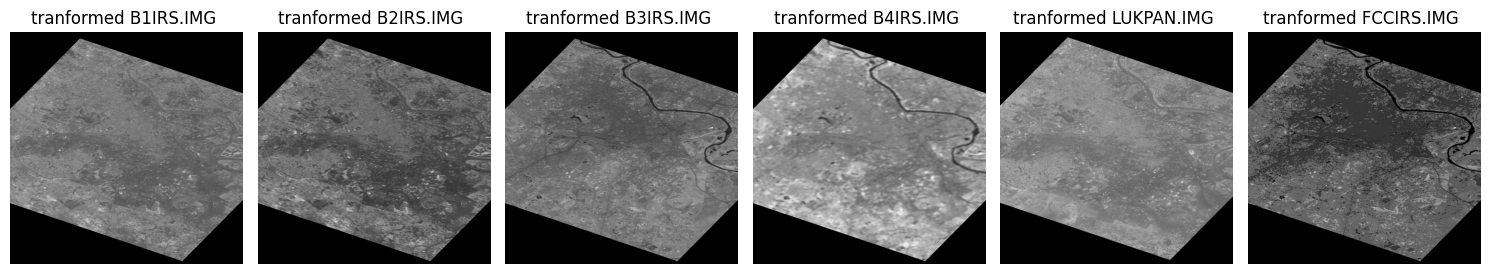

In [102]:
# display transformed image of each of the image after random transformation:scale =(1.2,0.7), translation = (10,5), shear factor = 0, rotation = 30, bicubic interpolation 
plt.figure(figsize=(15,20))
for i in range(len(file_path_arr)):
    plt.subplot(1,len(file_path_arr),i+1)
    transf_img = spatial_transform(selected_image[i],(1.2,0.7),(10,5),0,30,3)
    plt.imshow(transf_img, cmap="gray")
    plt.axis("off")
    plt.title(f"tranformed {file_path_arr[i]} ")

plt.tight_layout()
plt.show()

#### **Creating a simple GUI for affine transformation**

In [103]:
# created a simple gui that takes image as well as image doc as input  
def read_metadata(doc_path):
    """
    Reads metadata from the .DOC file and returns a dictionary of values.
    Expected keys: "rows", "columns", "data type", etc.
    """
    try:
        with open(doc_path, 'r') as doc_file:
            metadata = {}
            for line in doc_file:
                parts = line.strip().split(':')
                if len(parts) == 2:
                    key, value = parts[0].strip(), parts[1].strip()
                    metadata[key] = value
            return metadata
    except Exception as e:
        messagebox.showerror("Error", f"Failed to read metadata: {e}")
        return None

def load_img_file_np(img_path, metadata):
    """
    Loads the .IMG file using NumPy based on metadata dimensions.
    Expects metadata to include: "rows", "columns", and "data type".
    """
    try:
        rows = int(metadata.get("rows", 512))
        cols = int(metadata.get("columns", 512))
        dtype = np.uint8 if metadata.get("data type", "").lower() == "byte" else np.float32
        
        with open(img_path, 'rb') as img_file:
            data = np.fromfile(img_file, dtype=dtype)
            image = data.reshape((rows, cols))
        return image
    except Exception as e:
        messagebox.showerror("Error", f"Failed to load .IMG file: {e}")
        return None

def display_image(image, title="Image"):
    """
    Displays a given image in a new Toplevel window.
    """
    # Convert NumPy array to PIL Image
    pil_img = Image.fromarray(image)
    img_tk = ImageTk.PhotoImage(pil_img)
    top = tk.Toplevel()
    top.title(title)
    label = tk.Label(top, image=img_tk)
    label.image = img_tk  # Keep reference to avoid garbage collection
    label.pack()

In [104]:
# GUI: Main Function
def main_gui():
    global root
    root = tk.Tk()
    root.title("My(220122) Affine Transformation GUI")
    root.geometry("300x400")
    
    # Global variables to hold the loaded and transformed images
    root.loaded_image = None
    root.transformed_image = None
    
    # Callback: Load image using NumPy based on metadata from .DOC file
    def load_and_display_image():
        img_path = filedialog.askopenfilename(title="Select .IMG File", filetypes=[("IMG Files", "*.IMG")])
        doc_path = filedialog.askopenfilename(title="Select Metadata File (.DOC)", filetypes=[("DOC Files", "*.DOC")])
        
        if not img_path or not doc_path:
            messagebox.showerror("Error", "Both .IMG and .DOC files must be selected!")
            return
        
        metadata = read_metadata(doc_path)
        if metadata is None:
            return
        
        loaded = load_img_file_np(img_path, metadata)
        if loaded is not None:
            root.loaded_image = loaded
            display_image(loaded, title="Original Image")
    
    # Callback: Apply affine transformation
    def apply_transformation():
        if root.loaded_image is None:
            messagebox.showerror("Error", "No image loaded!")
            return
        try:
            tx = float(entry_tx.get())
            ty = float(entry_ty.get())
            scale_x = float(entry_scale_x.get())
            scale_y = float(entry_scale_y.get())
            # Check if scale factors are zero
            if scale_x == 0 or scale_y == 0:
                messagebox.showerror("Error", "Scale factor cannot be 0!")
                return
            
            shear_deg = float(entry_shear.get())
            rotation_angle = float(entry_rotate.get())
            interp_method = interpolation_var.get()
            if interp_method == "Nearest":
                order_val = 0
            elif interp_method == "Bilinear":
                order_val = 1
            elif interp_method == "Bicubic":
                order_val = 3
            else:
                order_val = 1
            
            transformed = spatial_transform(root.loaded_image, (scale_x, scale_y), (tx, ty), shear_deg, rotation_angle, order_val)
            root.transformed_image = transformed
            display_image(transformed, title="Transformed Image")
        except ValueError as ve:
            messagebox.showerror("Error", f"Invalid input: {ve}")
    
    # Callback: Save transformed image
    def save_transformed():
        if root.transformed_image is None:
            messagebox.showerror("Error", "No transformed image to save!")
            return
        save_path = filedialog.asksaveasfilename(defaultextension=".png", filetypes=[("PNG Files", "*.png"), ("JPEG Files", "*.jpg")])
        if save_path:
            try:
                Image.fromarray(root.transformed_image).save(save_path)
                messagebox.showinfo("Saved", f"Image saved to {save_path}")
            except Exception as e:
                messagebox.showerror("Error", f"Failed to save image: {e}")
    
    # Build GUI Layout:
    # Row 0: Load Image Button
    tk.Button(root, text="Load .IMG and Metadata (.DOC)", command=load_and_display_image).grid(row=0, column=0, columnspan=2, pady=10)
    
    # Row 1-2: Translation
    tk.Label(root, text="Translation X:").grid(row=1, column=0, sticky="e")
    entry_tx = tk.Entry(root, width=10)
    entry_tx.insert(0, "0")
    entry_tx.grid(row=1, column=1, pady=5)
    
    tk.Label(root, text="Translation Y:").grid(row=2, column=0, sticky="e")
    entry_ty = tk.Entry(root, width=10)
    entry_ty.insert(0, "0")
    entry_ty.grid(row=2, column=1, pady=5)
    
    # Row 3-4: Scaling
    tk.Label(root, text="Scale X:").grid(row=3, column=0, sticky="e")
    entry_scale_x = tk.Entry(root, width=10)
    entry_scale_x.insert(0, "1")
    entry_scale_x.grid(row=3, column=1, pady=5)
    
    tk.Label(root, text="Scale Y:").grid(row=4, column=0, sticky="e")
    entry_scale_y = tk.Entry(root, width=10)
    entry_scale_y.insert(0, "1")
    entry_scale_y.grid(row=4, column=1, pady=5)
    
    # Row 5: Shear
    tk.Label(root, text="Shear (°):").grid(row=5, column=0, sticky="e")
    entry_shear = tk.Entry(root, width=10)
    entry_shear.insert(0, "0")
    entry_shear.grid(row=5, column=1, pady=5)
    
    # Row 6: Rotation
    tk.Label(root, text="Rotation (°):").grid(row=6, column=0, sticky="e")
    entry_rotate = tk.Entry(root, width=10)
    entry_rotate.insert(0, "0")
    entry_rotate.grid(row=6, column=1, pady=5)
    
    # Row 7: Interpolation Method
    tk.Label(root, text="Interpolation:").grid(row=7, column=0, sticky="e")
    interpolation_var = tk.StringVar(value="Bilinear")
    interp_dropdown = ttk.Combobox(root, textvariable=interpolation_var, values=["Nearest", "Bilinear", "Bicubic"], state="readonly", width=10)
    interp_dropdown.grid(row=7, column=1, pady=5)
    
    # Row 8: Action Buttons (Apply Transformation, Save)
    tk.Button(root, text="Apply Transformation", command=apply_transformation).grid(row=8, column=0, pady=10)
    tk.Button(root, text="Save Transformed Image", command=save_transformed).grid(row=8, column=1, pady=10)
    
    root.mainloop()

if __name__ == "__main__":
    main_gui()
